# Анализ результатов А/В теста и приоритизация гипотез

Мне передали данные с гипотезами и данные по посещениям, покупкам на сайте, разделенные по группам. Необходимо посмотреть различия по приоритизациям гипотез, используя фреймворк ICE и RICE. Также необходимо провести A/B тест, опираясь на полученные данные по посещаемости и заказам.
Для начала оценим, как собраны данные, их характер, формат, приведем форматы к нужным, если потребуется.
Далее с помощью фреймворков ICE-RICE проведем приоритизацию гипотез, оценим разницу в полученных результатах.
Затем на основе имеющихся файлов проведем A/B тест, вынесем решение продолжить или завершить тест.

# План

- [Предобработка данных](#предобработка)
- [Приоритизация гипотез методами ICE-RICE](#приоритизация)
- [A/B тестирование](#тестирование)
- [Выводы](#вывод)

# Обработка данных <a id='предобработка'></a>

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats

hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [3]:
orders = pd.read_csv('/datasets/orders.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [4]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [5]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [6]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [7]:
visitors_duplicated = visitors[visitors.duplicated()]
len(visitors['date'].unique())

31

In [32]:
orders_duplicated = orders[orders.duplicated()]
group_a_visitor_id = orders[orders['group'] == 'A']['visitorId']
filter_orders = orders['visitorId'].isin(group_a_visitor_id)
result = orders[filter_orders]
coincidence = result[result['group'] == 'B']['visitorId']
coincidence.nunique()

58

По предварительной оценке данных можно скаазать, что каких-то серьезных работ по исправлению форматов или чистки датасэтов не требуется. Единственное - необходимо привести date в orders, visitors к формату даты. Есть только проблема с тем, что 58 пользователя попали в две группы теста сразу

# Приоритизация гипотез фреймворками ICE-RICE <a id='приоритизация'></a>

In [9]:
hypothesis_ice = hypothesis
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
hypothesis_ice['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence'])/hypothesis['Efforts']
hypothesis_ice[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round()

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


In [10]:
hypothesis = hypothesis.drop('ICE', axis=1)
hypothesis_rice = hypothesis
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
hypothesis_rice['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'])/hypothesis['Efforts']
hypothesis_rice[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


При использовании разных фреймворков видим разницу в приоритизации гипотез. Разница достигается за счет того, что во фреймворке RICE добавляется покзатель Reach, который подразумевает, скольких пользователей затронет изменение, которое вы хотите внести, то есть "охват". Соответсвенно из-за этого возникает разница, так как у некоторых гипотез изменения для сайта/приложения охватывает всех пользователей и показатель идет высоким, из-за чего конечный результат выше (ориентировано не всех пользователей, а не только на платящих). В приоритете гипотезы 7,0,6

# А/В тестирование <a id='тестирование'></a>

## Кумулятивная выручка по группам

Соберём агрегированные кумулятивные по дням данные о заказах. Получим агрегированные кумулятивные по дням данные о посетителях 

In [11]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

Объединим обе таблицы в одну

In [12]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


Строим графики кумулятивной выручки по группам

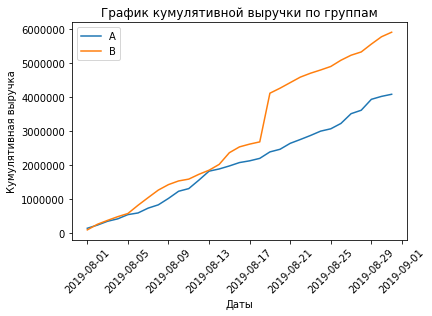

In [33]:
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date','revenue','orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date','revenue','orders']]

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.xticks (rotation = 45)
plt.legend()
plt.xlabel('Даты')
plt.ylabel('Кумулятивная выручка')
plt.title('График кумулятивной выручки по группам')
plt.show()

Примерно до середины теста группы идут близко друг к другу, потом группа В вырывается вперед. Вероятно имеют место быть выбросы (большие заказы)

## Кумулятивный средний чек по группам

Строим графики кумулятивного среднего чека по дням для каждой группы

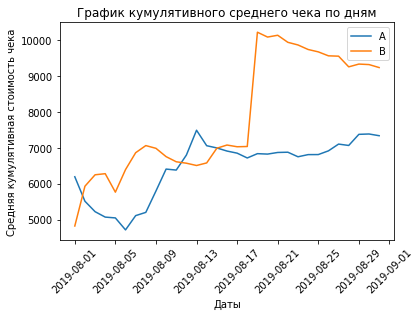

In [34]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.xticks (rotation = 45)
plt.legend()
plt.ylabel('Средняя кумулятивная стоимость чека')
plt.xlabel('Даты')
plt.title('График кумулятивного среднего чека по дням')
plt.show()

Имеется резкий рост в группе В, необходимо посмотреть данные на предмет выбросов (большие заказы), исключить их из анализа

## Относительное изменение кумулятивного среднего чека В к А

Объединяем таблицы с кумулятивными данными по выручке, строим график

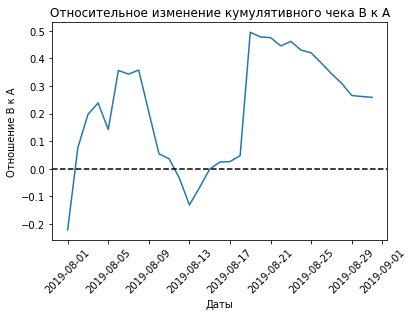

In [36]:
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks (rotation = 45)
plt.title('Относительное изменение кумулятивного чека В к А')
plt.ylabel('Отношение В к А')
plt.xlabel('Даты')
plt.show()

Налицо резкие изменения графика, что также говорит о наличии больших заказов

## Кумулятивная конверсия по группам

Добавляем в таблицу столбец c отношением числа заказов к количеству пользователей в указанной группе в указанный день (добавленов в пункте 2 после объединения таблиц) 2019-08-01 min 2019-08-31max

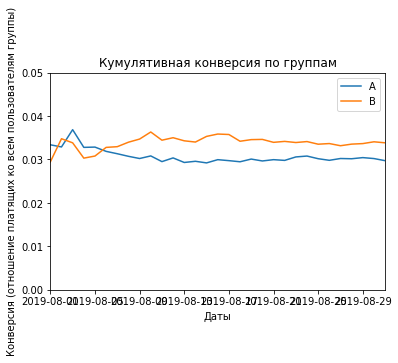

In [16]:
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']


cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis(['2019-08-01', '2019-08-31', 0, 0.05])
plt.title ('Кумулятивная конверсия по группам')
plt.ylabel('Конверсия (отношение платящих ко всем пользователям группы)')
plt.xlabel('Даты')
plt.show()

После некоторого колебания графика в начале теста график выровнялся, группа В и тут имеет большее значение конверсии перед группой А

## Относительное изменение кумулятивной конверсии группы B к группе A

Объединим таблицы, построим графики

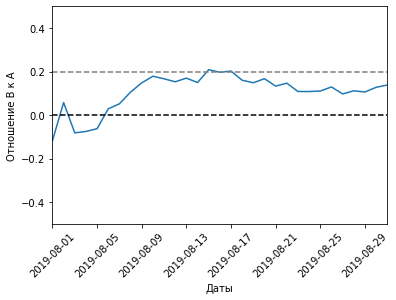

In [37]:
merged_сumulative_сonversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_сumulative_сonversions['date'], merged_сumulative_сonversions['conversionB']/merged_сumulative_сonversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.xticks (rotation = 45)
plt.axis(['2019-08-01', '2019-08-31', -0.5, 0.5])
plt.ylabel('Отношение В к А')
plt.xlabel('Даты')
plt.show()

Группа В выше по конверсии относительно группы А, конверсия остановилась около прироста в 20%, потом снизилась примерно до 15%

## Точечный график заказов по пользователям + перцентили

Отсортируем таблицу с заказами по пользователям и построим точечный график для поиска больших заказов

In [18]:
orders_by_users = orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'}).sort_values(by='transactionId',ascending=False)
orders_by_users.columns = ['userId', 'orders']
orders_by_users

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
...,...,...
359,1484903144,1
360,1485964287,1
361,1494664757,1
362,1495112755,1


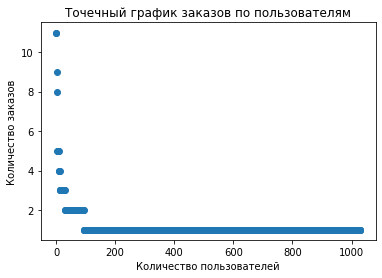

In [19]:
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'])
plt.title('Точечный график заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xlabel('Количество пользователей')
plt.show()

In [20]:
np.percentile(orders_by_users['orders'], [90,95,99])

array([1., 2., 4.])

Подавляющее большинство пользователей делали по одному заказу, 5% - по 2 заказа, 1% - более двух. На мой взгляд, было бы разумно ограничить выборку теми пользователями, кто делал максимум 1-2 заказа.

## Точечный график стоимостей заказов + перцентили

Отсортируем таблицу по стоимостям заказаов, построим точечный график для определения больших заказов, посчитаем перцентили для определения границы

In [21]:
orders.sort_values(by='revenue', ascending=False)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
...,...,...,...,...,...
933,3760662696,3577713868,2019-08-27,60,B
459,863448794,2738601405,2019-08-19,50,B
756,125335873,3423937755,2019-08-30,50,B
584,1126146019,2705308997,2019-08-20,50,A


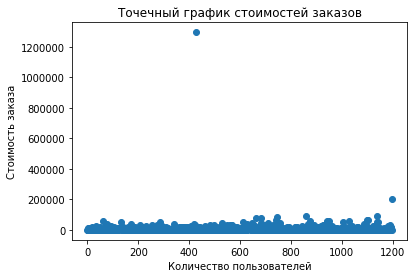

In [22]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа')
plt.xlabel('Количество пользователей')
plt.show()

In [23]:
np.percentile(orders['revenue'], [90,95,99])

array([18168. , 28000. , 58233.2])

Не более, чем у 5% пользователей стоимость заказов достигала 28 тыс у.е., и не более 1%  - 58233.2 у.е. На мой взгляд, было бы разумнее также ограничить выборку по 50 тыс у.е.

## Статистическая значимость различий в конверсии между группами по «сырым» данным

Определим сколько посетителей из каждой группы было в день, сделаем кумулятивныю таблицу для обеих групп пользователей. То же самое сделаем с количеством заказов для обеих групп пользователей. Объединяем все имеющиеся таблицы по датам. Далее проводим тест Манна-Уитни, чтобы понять, есть ли статистическая значимость в различии в конверсии между группами по "сырым данным".
Нулевая гипотеза: Между группами нет статистически значимого различия
Обратная : Между группами есть статистически значимое различие

In [24]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitorId': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitorId', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitorId', 'orders']

sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

print("{0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

0.00840


In [25]:
'{0:.3f}'.format((data['orders_per_date_b'].sum()/data['visitors_per_date_b'].sum())/(data['orders_per_date_a'].sum()/data['visitors_per_date_a'].sum())-1)

'0.117'

Статистически значимых различий между группами нет. Дополнительно посчитал относительный прирост конверсии В к А. Группа В выглядит лучше на протяжение теста

##  Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

In [26]:
'{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])

'0.365'

In [27]:
'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

'0.259'

Статистически значимых различий между группами по среднему чеку по сырым данным нет. Дополнительно посчитал относительный прирост среднего чека, группа В смотрится гораздо лучше

## Статистическая значимость различий в конверсии между группами по «очищенным» данным

Для начала нужно определить аномальных пользователей, их, как я упоминал выше, стоит выделить по таким критериям: больше 2 заказов и заказы дороже 50 ты у.е.

In [28]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 2]['visitorId'],
        orders_by_users_b[orders_by_users_b['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 50000]['visitorId']
ab_normal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitorId'].isin(ab_normal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitorId'].isin(ab_normal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

'{0:.5f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1])

'0.00410'

In [29]:
'{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)

'0.182'

По очищенным данным видим, что между группами появилась статистическая значимость различия между группами. Значит мы убрали выбросы и шума в данных стало меньше. Группа В смотрится по конверсии лучше относительно группы А

## Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [30]:
'{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(ab_normal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(ab_normal_users)),
                )
            ]['revenue'],
        )[1]
    )

'0.470'

Дополнительно посчитал относительный прирост среднего чека

In [31]:
"{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(ab_normal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(ab_normal_users)),
            )
        ]['revenue'].mean()
        - 1
    )

'0.019'

По очищенным данным видим, что статистической значимости различия между группами по среднему чека нет, а относительный прирост среднего чека стал незначительным у группы В относительно А

# Выводы по проекту

На этапе предобработки данных не нашел сырьезных проблем с данными, форматы выправил, выгрузка почти корректная. Единственной проблемой стало то, что 58 пользователей попали  сразу в обе группы теста, что искажает данные.

По приоритезации гипотез сделал следующий вывод, что методы ICE и RICE различаются тем, что фреймворк RICE предполагает еще показатель охвата гипотезы, то есть как изменения повлияют на всех пользователей. Из-за этого менятеся порядок ранжирования гипотез. Но в целом прише к выводу, что для начала стоит проверить гипотезы 7 0 и 6.

В целом между группами не наблюдается статистической значимости различия между группами, кроме как в конверсии по ощищенным данным. Если по сырым данным мы наблюдаем, что результаты группы В относительно А гораздо лучше, то уже по очищенным данным видно, что появилась статистическая значимость различия между группами В и А, относительная конверсия В к А достаточно высокая - 18%, но при этом относительный прирост среднего чека составляет только 2%
При этом результаты группы В все равно смотрятся лучше, и, вероятно, результаты группы А не улучшатся. Тест можно остановить.